## Gene Expression (SARS, MERS, SARS2)

Download RAW data and series matrix from GEO
- Microarray 
 * [GSE28166](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE28166), [raw data](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE28166&format=file), [series matrix](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE28nnn/GSE28166/matrix/GSE28166_series_matrix.txt.gz)
 * [GSE33267](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE33267), [raw data](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE33267&format=file), [series matrix](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE33nnn/GSE33267/matrix/GSE33267_series_matrix.txt.gz)
 * [GSE37571](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37571), [raw data](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE37571&format=file), [series matrix](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE37nnn/GSE37571/matrix/GSE37571_series_matrix.txt.gz)
 * [GSE45042](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE45042), [raw data](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE45042&format=file), [series matrix](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE45nnn/GSE45042/matrix/GSE45042_series_matrix.txt.gz)
 * [GSE56677](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE56677), [raw data](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE56677&format=file), [series matrix](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE56nnn/GSE56677/matrix/GSE56677_series_matrix.txt.gz)
- RNASeq
 * [GSE147507](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE147507) (Human), [raw data](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE147507&format=file&file=GSE147507%5FRawReadCounts%5FHuman%2Etsv%2Egz), [GSE147507-GPL18573_series_matrix](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE147nnn/GSE147507/matrix/GSE147507-GPL18573_series_matrix.txt.gz)
 * [GSE148729](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148729) (totalRNA), [raw data](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE148729&format=file&file=GSE148729%5FCalu3%5FtotalRNA%5Freadcounts%2Etxt%2Egz), [GSE148729-GPL20301_series_matrix](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE148nnn/GSE148729/matrix/GSE148729-GPL20301_series_matrix.txt.gz)

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [3]:
import subprocess as sp

## Microarray

#### Metadata

In [4]:
def add_properties_to_metadata(data, sep='_', properties={} ):
    for prop,position in properties.items():
        data[prop] = data['ID'].apply(lambda x: x.split(sep)[position])
    if 'Time' in properties:
        data['Time']=data['Time'].str.upper().apply(lambda x: x[:-1] if x[-1]=='R' else x)
    
    return data

In [5]:
def create_metadata_structure(data):
    data=pd.DataFrame(data.loc['!Sample_geo_accession'])
    data['ID']=data.index
    data.index=data['!Sample_geo_accession']
    del data['!Sample_geo_accession']
    
    return data

In [6]:
def save_metadata_microarray(accession, firstrow, virus='not_mock', sep='_', properties = {'Virus':1, 'Time':2, 'Replicate':3}):
    """
    Save Microarray metadata to csv (accession_meta.csv)
    :param accession: geo accession lowercase
    :param firstrow: read_csv skip first x row
    :param virus: if virus is not mock set virus name (eg. WT)
    :param sep: split ID by this separator 
    :param properties: dictionary: set position of properties (eg. Time) in ID
    """
    data=pd.read_csv(f'../data/{accession.lower()}/{accession.upper()}_series_matrix.txt',
                     sep='\t',skiprows=firstrow,low_memory=False,index_col=0)
    data = create_metadata_structure(data)
    data = add_properties_to_metadata(data, sep, properties)
    
    data['Virus'].replace('mock','Mock',inplace=True)
    if virus == 'not_mock': 
        not_mock = data['Virus']!='Mock'
    else: 
        not_mock = data['Virus']==virus
    
    data.loc[data.index[not_mock],'Virus']=f'{accession.upper()}_Virus'
    data.to_csv(f'../data/{accession.lower()}/{accession.lower()}_meta.csv',sep=',')

In [7]:
save_metadata_microarray('gse28166', 37, properties = {'Virus':0, 'Time':1, 'Replicate':2})
save_metadata_microarray('gse33267', 35, sep=' ', virus='WT')
save_metadata_microarray('gse37571', 31)
save_metadata_microarray('gse45042', 39)
save_metadata_microarray('gse56677', 35)

#### Gene expression

##### Normalizing raw data

In [8]:
def runR(script, output = True):
    result = sp.run(['/usr/local/bin/Rscript', '--verbose', script], capture_output=True)
    print(result)
    if result.stderr:
        print("Error: ")
        print(result.stderr)
    
    if output: 
        print("Result: ")
        print(result.stdout)
        
    return

##### Save normalized data

In [9]:
def save_gene_expression_microarray(accession, split_by='_'):
    """
    Save normalized microarray gene expression data to csv (accession_gex.csv)
    :param accession: GEO accession (lowercase)
    :param split_by: split data columns by this character
    """
    accession = accession.lower()
    data=pd.read_csv(f'../data/{accession}/{accession}_norm_mean.csv',sep=',',header=0,index_col=0)
    meta=pd.read_csv(f'../data/{accession}/{accession}_meta.csv',sep=',',header=0,index_col=0)
    data.columns=pd.Series(data.columns).apply(lambda x:x.split(split_by)[0])
    #assert len(set(data.columns)-set(meta.index))==0
    data=data[meta.index]
    data.to_csv(f'../data/{accession}/{accession}_gex.csv')

In [10]:
save_gene_expression_microarray('gse28166', split_by='.')
save_gene_expression_microarray('gse33267')
save_gene_expression_microarray('gse37571')
save_gene_expression_microarray('gse45042')
save_gene_expression_microarray('gse56677')

## RNA Seq

### GSE147507

#### Metadata

In [11]:
series_matrix=pd.read_csv('../data/gse147507/GSE147507-GPL18573_series_matrix.txt'
                          ,sep='\t',header=0,index_col=0,skiprows=31)
metadata = create_metadata_structure(series_matrix)

In [12]:
metadata = add_properties_to_metadata(metadata, properties = {'Series':0, 'Cell':1, 'Treatment':2})
metadata.iloc[[-4,-3,-2,-1],[-2,-1]]=[['Lung','Healthy'],['Lung','Healthy'],['Lung','COVID19'],['Lung','COVID19']]
metadata['Virus']=1
metadata.loc[metadata['Treatment'].str.contains('Mock|Healthy', regex=True), 'Virus'] = 0
metadata.to_csv('../data/gse147507/meta.csv')

#### Gene expression

In [13]:
data=pd.read_csv('../data/gse147507/GSE147507_RawReadCounts_Human.tsv',sep='\t',header=0,index_col=0)

In [14]:
data=data[metadata['ID'].values]
data.columns=metadata.index

In [15]:
data.to_csv('../data/gse147507/GSE147507_raw.csv',sep=',')

##### Differential expression analysis

In [16]:
#runR("gse147507_DE.R")

##### PC anaysis

In [17]:
model=PCA(2)
data_pca=pd.DataFrame(model.fit_transform(data.T),index=data.columns,columns=['PC1','PC2'])

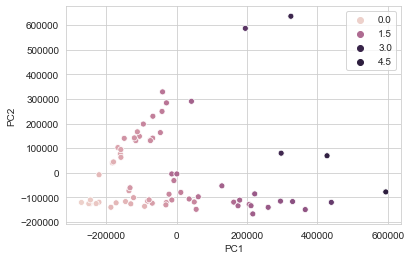

In [18]:
sns.scatterplot(data_pca['PC1'],data_pca['PC2'],hue=data.sum())
plt.show()

### GSE148729

##### Gene name conversion from ENSEMBL ID to HGNC symbol

In [19]:
data=pd.read_csv('../data/gse148729/Calu3_totalRNA_readcounts.txt',sep='\t',low_memory=False,index_col=0)

In [20]:
name_conversion = pd.read_csv('../data/gse148729/gse148729_name_conversion.csv', sep=',', index_col=0)

In [21]:
name_conversion = name_conversion[name_conversion.hgnc_symbol.notna()].drop_duplicates('hgnc_symbol')

In [22]:
data = data.reset_index()
data['ensembl_gene_id']= data.gene_id.str.split('.',expand=True)[0]
data = data.merge(name_conversion, 
                  left_on='ensembl_gene_id', 
                  right_on='ensembl_gene_id').set_index('hgnc_symbol').drop(columns=['gene_id', 'ensembl_gene_id'])

##### Metadata and gene expression

In [23]:
series_matrix=pd.read_csv('../data/gse148729/GSE148729-GPL20301_series_matrix.txt',sep='\t',skiprows=60,low_memory=False,index_col=0)

In [24]:
metadata = create_metadata_structure(series_matrix)
metadata = add_properties_to_metadata(metadata, sep='-', properties={'Treatment':1, 'Time':2, 'Replicate':3} )

In [25]:
# change sample ID to Sample_geo_accession
d = dict(map(reversed, metadata['ID'].to_dict().items()))
data.columns = data.columns.to_series().map(d)

In [26]:
metadata.to_csv('../data/gse148729/meta.csv')
data.to_csv('../data/gse148729/GSE148729_raw.csv')

###### Differencial expression analysis

In [27]:
### run deseq2 in R
#call(['RScript','gse148729_DE.R'])

##### PC analysis

In [28]:
vst = pd.read_csv('../results/gse148729/data_vst.csv', sep=',', index_col=0)
model=PCA(2)
vst_pca=model.fit_transform(vst.T)
vst_pca=pd.DataFrame(vst_pca,index=vst.columns,columns=['PC1','PC2'])

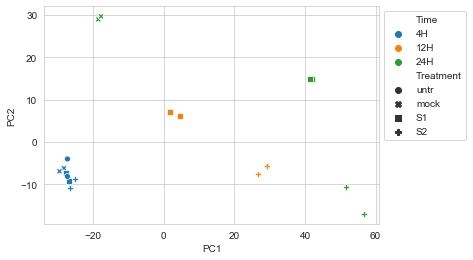

In [29]:
sns.scatterplot(vst_pca['PC1'],vst_pca['PC2'], hue_order = ['4H', '12H', '24H'], hue=metadata['Time'],
                style=metadata['Treatment'], style_order=['untr','mock','S1','S2'])
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Merge

In [40]:
dnames=['gse28166','gse33267','gse37571','gse45042','gse56677']+['gse147507']*11+['gse148729']*4
fnames=['gse28166_DE','gse33267_DE','gse37571_DE','gse45042_DE','gse56677_DE']+\
        ['series1_DE','series2_DE','series3_DE','series4_DE','series5_DE','series6_DE','series7_DE','series8a_DE']+\
        ['series8b_DE','series9_DE','series15_DE']+\
        ['gse148729_DE_mock_S1_4H', 'gse148729_DE_mock_S2_4H', 'gse148729_DE_mock_S1_24H', 'gse148729_DE_mock_S2_24H']
data={}

In [41]:
for i in range(len(dnames)):
    data[fnames[i]]=pd.read_csv('../data/%s/%s.csv' % (dnames[i],fnames[i]),sep=',',header=0,index_col=0)

In [42]:
data['gse148729_DE_mock_S1_4H']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TSPAN6,835.490187,-0.227968,0.161151,-1.414620,0.157180,NaN
DPM1,700.023036,-0.081032,0.160045,-0.506309,0.612640,NaN
SCYL3,197.467816,0.109047,0.249498,0.437064,0.662065,NaN
C1orf112,336.503181,0.071293,0.206622,0.345040,0.730065,NaN
FGR,0.593175,0.394332,4.206908,0.093735,0.925320,NaN
...,...,...,...,...,...,...
ASDURF,88.908432,-0.062133,0.347622,-0.178737,0.858144,NaN
RCAN3AS,5.295571,-0.170827,1.317524,-0.129658,0.896837,NaN
DERPC,467.583834,-0.059529,0.184201,-0.323173,0.746564,NaN
RNVU1-8,0.223785,-1.237515,4.994031,-0.247799,0.804290,NaN


In [43]:
# Filter same genes from all dataset (8710 were dropped)
genes=set(data['gse28166_DE'].index)
for dname in data.keys():
    genes=genes&set(data[dname].index)
genes=list(genes)
for dname in data.keys():
    data[dname]=data[dname].loc[genes]

In [34]:
results=pd.DataFrame(index=genes,columns=data.keys())
for dname in results.columns:
    if 't' in data[dname].columns:
        results[dname]=data[dname]['t']
    else:
        results[dname]=data[dname]['stat']

In [35]:
columns_dict = {
    'gse28166_DE':'GSE28166_Calu3_H5N1',
     'gse33267_DE':'GSE33267_Calu3_SARS.CoV',
     'gse37571_DE':'GSE37571_Calu3_Influenza',
     'gse45042_DE':'GSE45042_Calu3_MERS',
     'gse56677_DE':'GSE56677_Calu3_MERS',
     'series1_DE':'GSE147507.S1_NHBE_SARS.CoV.2',
     'series2_DE':'GSE147507.S2_A549_SARS.CoV.2',
     'series3_DE':'GSE147507.S3_A549_RSV',
     'series4_DE':'GSE147507.S4_A549_IAV',
     'series5_DE':'GSE147507.S5_A549_SARS.CoV.2',
     'series6_DE':'GSE147507.S6_A549_ACE2.SARS.CoV.2',
     'series7_DE':'GSE147507.S7_Calu3_SARS.CoV.2',
     'series8a_DE':'GSE147507.S8_A549_RSV',
     'series8b_DE':'GSE147507.S8_A549_HPIV',
     'series9_DE':'GSE147507.S9_NHBE_IAV',
     'series15_DE':'GSE147507.S15_Infected.Lung_SARS.CoV.2',
     'gse148729_DE_mock_S1_4H':'GSE148729_Calu3_SARS.CoV_4H',
     'gse148729_DE_mock_S2_4H':'GSE148729_Calu3_SARS.CoV_24H',
     'gse148729_DE_mock_S1_24H':'GSE148729_Calu3_SARS.CoV.2_4H',
     'gse148729_DE_mock_S2_24H':'GSE148729_Calu3_SARS.CoV.2_24H'}

In [36]:
results = results.rename(columns=columns_dict)

In [37]:
results.to_csv('../results/microarray_and_rnaseq_expression.csv')

In [38]:
results.iloc[:10, :5]

,GSE28166_Calu3_H5N1,GSE33267_Calu3_SARS.CoV,GSE37571_Calu3_Influenza,GSE45042_Calu3_MERS,GSE56677_Calu3_MERS
TOR1AIP1,-0.265855,-1.506547,4.691753,4.457274,-0.901465
TMEM126A,1.719826,-1.776039,-2.975716,-4.269872,-1.542372
BRD8,-12.437209,2.327074,-9.176630,1.118141,-1.332901
DAPP1,-13.756992,7.007527,4.655702,11.564376,5.867346
SLC27A2,-19.058259,-1.693200,-3.348291,-3.229593,-5.023152
TNFAIP8,-5.949700,-2.491375,3.565728,1.595638,-2.186632
FZD7,-6.987377,-1.405584,-0.093153,-9.756436,-0.542419
RPS4X,-3.091146,-1.805310,-4.770010,-0.648007,-2.558815
TMSB15B,6.332637,1.642774,-5.477011,4.329035,0.682380
POLR3D,-4.440179,-0.695539,3.294593,9.153592,2.625260
